In [1]:
import numpy as np
import pointCollection as pc
import matplotlib.pyplot as plt
from scipy.stats import chi2
#%matplotlib widget

# Simulation parameters

In [2]:
# DEM parameters
N_DEM = 1024 # DEM samples
A_exponent  = -2.5 # red-noise exponent in the DEM
DEM_sigma = 100 # RMS of the DEM elevations
DEM_samp_interval = 1 # spacing between DEM samples

# True horizonal offset
true_offset = [-5.3, 7.1]  # arbitrary true offset to apply to the tracks

# Track parameters
sampling_interval = 10  # along-track sampling interval
track_spacing = 250     # track-to-track spacing
track_azimuth = 60      # Azimuth of tracks relative to grid x vector

# Data errors:
data_sigma = 1

# search parameters:
max_offset = 20  # this is the maximum offset we will attempt in searching for the best-fitting shift
delta_tol = 0.01 # We will search with a horizontal tolerance of 0.01

# generate a random red-noise DEM


In [3]:
W_DEM=DEM_samp_interval*N_DEM
k=np.fft.fftfreq(N_DEM)
kx, ky=np.meshgrid(k,k)
kr=np.abs(kx+1j*ky)
kr[kr==0]=1
# fft phase
ph=np.fft.fft2(np.random.randn(N_DEM,N_DEM))

#DEM is the ifft of fft phase * radial wavenumber **A_exponent
DEM=pc.grid.data().from_dict(dict(x=np.arange(N_DEM)*DEM_samp_interval, y=np.arange(N_DEM)*DEM_samp_interval, z=np.real(np.fft.ifft2(kr**A_exponent*ph))))
DEM.__update_size_and_shape__()

DEM.z *= DEM_sigma/np.std(DEM.z)

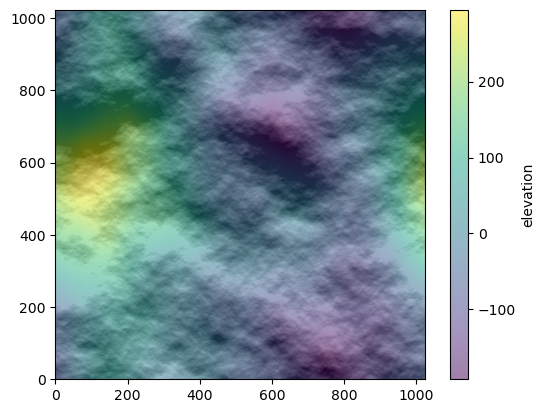

In [4]:
plt.figure()
DEM.show(gradient=True)
hi=DEM.show(alpha=0.5)
plt.colorbar(hi, label='elevation')

# generate tracks


In [5]:

# along-track vector
v_AT=np.exp(1j*track_azimuth*np.pi/180)
v_AT/=np.abs(v_AT)
v_XT = 1j*v_AT

tracks=[]

# along-track sample spacing
x_AT = np.arange(-W_DEM*1.414, W_DEM*1.414, sampling_interval)

# offset tracks by track_spacing in the across-track direction
for count, x0 in enumerate(np.arange(-W_DEM, 2*W_DEM, track_spacing)):
    for BVi in v_AT, np.conj(v_AT):
        tracks += [
            pc.data().from_dict({'x': np.real(x_AT*BVi) + np.real(1j*BVi)*x0 + W_DEM/2, 
                                 'y': np.imag(x_AT*BVi) + np.imag(1j*BVi)*x0 + W_DEM/2,
                                 'track':len(tracks)+np.zeros_like(x_AT)})]


# collect tracks into a single structure
tracks=pc.data().from_list(tracks)
tracks.assign(t=tracks.track/4)
tracks.crop(DEM.bounds())

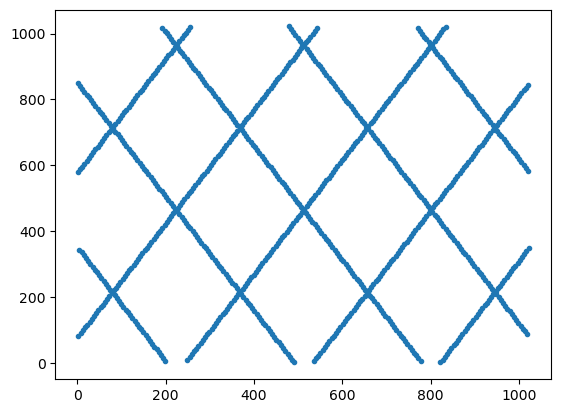

In [6]:
plt.figure()
plt.plot(tracks.x, tracks.y,'.')

In [7]:
tracks

<class 'pointCollection.data.data'> with shape (835,),
with fields:
['x', 'y', 'track', 't']

### Sample the DEM

In [8]:
tracks.assign(z=DEM.interp(tracks.x+true_offset[0], tracks.y+true_offset[1]))
tracks.z += data_sigma * np.random.randn(*tracks.shape)
tracks.assign(sigma=data_sigma * np.ones_like(tracks.z))

<class 'pointCollection.data.data'> with shape (835,),
with fields:
['x', 'y', 'track', 't', 'z', 'sigma']

### Assign the DEM a time in the middle of the track sampling

In [9]:
DEM.t=np.mean(tracks.t)

# Select data points

We will be searching data offsets that minimize mismatch with the DEM.  To ensure that the same points are sampled for each offset, we will select points that are valid under the maximum offsets considered


In [10]:
?pc.register_grid.select_valid_pts

Signature: pc.register_grid.select_valid_pts(D_pt, D_grid, max_dist, max_dt=None)
Docstring:
Choose the point data that will be present for any allowable shift

Parameters
----------
D_pt : pointCollection.data
    Point altimetry data to which the DEM is registered.
D_grid : pointCollection.grid.data
    grid data to be registered.
max_dist : float
    maximum distance that the DEM might be displaced.
max_dt : float
    maximum allowed time between a data point and the DEM

Returns
-------
good : np.array (boolean)
    Points that should be used.
File:      ~/git_repos/pointCollection/pointCollection/tools/register_grid.py
Type:      function

0.9281437125748503


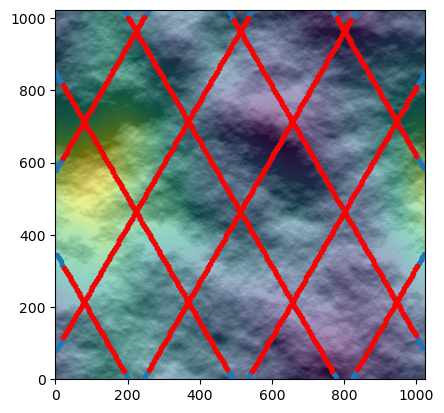

In [11]:
valid=pc.register_grid.select_valid_pts(tracks, DEM, max_offset, max_dt=5)

print(np.mean(valid))
tracks_sub=tracks[valid]

plt.figure()
DEM.show(gradient=True)
DEM.show(alpha=0.5)
plt.plot(tracks.x, tracks.y,'.')
plt.plot(tracks_sub.x, tracks_sub.y,'r.')

# Search for best-fitting offsets

Search_offsets shifts the data points by a set of offsets, and calculates the mismatch between the points and the DEM at each offset.  The mismatch allows for a tilt in x and y and a linear rate of elevation change.

In [12]:
?pc.register_grid.search_offsets

Signature:
pc.register_grid.search_offsets(
    D_pt,
    D_grid,
    max_delta=10,
    delta_tol=1,
    sigma_min=0.02,
)
Docstring:
Search offsets to find the optimum residual

Parameters
----------
D_pt : pointCollection.data
    Reference point data.
D_grid : pointCollection.grid.data
    grid data to be registered.
max_delta : float, optional
    largest offset attempted. The default is 10.
delta_tol : float, optional
    Convergence tolerance for offset search. The default is 1.
sigma_min : float, optional
    Minimum value for estimated data errors. The default is 0.1.

Returns
-------
best_offset : list (2)
    x and y shift for minimum residual.
R_of_delta : dict
    Dict specifying the residual for all tested offsets.
File:      ~/git_repos/pointCollection/pointCollection/tools/register_grid.py
Type:      function

In [13]:
best_offset, R_of_delta = pc.register_grid.search_offsets(tracks_sub, DEM, max_delta=max_offset, delta_tol=0.01, sigma_min=0.1)

# Compare the recovered offset to the true offset

In [14]:
[best_offset, true_offset]

[(-5.3515625, 6.9921875), [-5.3, 7.1]]

# plot the results

The R_of_delta dictionary contains the offsets attempted and the measured residual at each.  We will assume that $R^2  \approx \chi^2/N_{DF}$, and $N_{DF} = N_{data}-5$, so the confidence for each residual is given by the CDF of the $\chi^2$ distribution of the residual.  We'll make a scatter plot showing the points searched


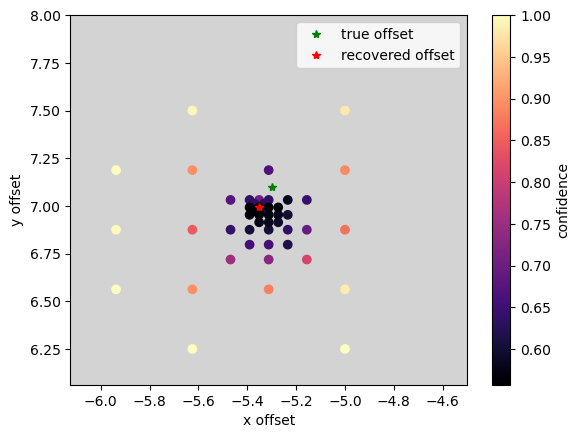

In [16]:
dxy = np.c_[list(R_of_delta.keys())]
R_of_dxy = np.array(list(R_of_delta.values()))
plt.figure()

# assume that the residuals are distribute as a chi2 with 5 degrees of freedom:
#  (xy location, three model-fit parameters)
P_chi2 = chi2.cdf(R_of_dxy**2/np.min(R_of_dxy**2)*(tracks_sub.size), tracks_sub.size-5 )

# scatter plot of residual distribtion
ii = np.argsort(-R_of_dxy)
h_sc=plt.scatter(*dxy[ii,:].T, c=P_chi2[ii], cmap='magma')#, clim=np.min(R_of_dxy)*np.array([1, sigma_scale]))

plt.plot(*true_offset,'g*', label='true offset')
plt.plot(*best_offset,'r*', label='recovered offset')


plt.colorbar(h_sc, label='confidence')
plt.gca().set_xlabel('x offset')
plt.gca().set_ylabel('y offset')
plt.gca().set_facecolor('lightgray')


# select the axis bounds corresponding to the 99% confidence interval +- 0.5

temp=pc.data().from_dict({'x':dxy[:,0], 'y':dxy[:,1],'P_chi2':P_chi2})
temp.ravel_fields()
temp=temp[temp.P_chi2 < 0.99]
plt.gca().set_xlim(temp.bounds(pad=0.5)[0])
plt.gca().set_ylim(temp.bounds(pad=0.5)[1])

plt.legend()